# Format GSE12290 for analysis

Tong Shu Li

### Main steps

1. Read GSE12290 series matrix
2. Annotate with sample metadata
3. Annotate genes with WormBase identifiers

In [1]:
import pandas as pd
import seaborn as sns
import sys

In [2]:
%matplotlib inline

In [3]:
sys.path.append("../..")

In [4]:
from src.geo import parse_series_matrix

from src.util import read_file

---

## Read GSE12290

Steps:
1. Read the metadata and expression values.
2. Reshape and add metadata for each sample.

In [5]:
series, samples, exp = parse_series_matrix("GSE12290_series_matrix.txt")

In [6]:
samples.shape

(104, 42)

In [7]:
samples.head(2)

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_phone,contact_laboratory,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,data_row_count
0,tg10,GSM308821,Public on Sep 16 2008,Jul 30 2008,Sep 16 2008,RNA,2,"Individual C. elegans, age: 8 days old",Caenorhabditis elegans,8 day old N2 raised under standard conditions ...,...,415 209 2068,Melov Lab,Buck Institute for Research on Aging,8001 Redwood Blvd,Novato,CA,94945,USA,ftp://ftp.ncbi.nlm.nih.gov/pub/geo/DATA/supple...,22490
1,tg100,GSM308822,Public on Sep 16 2008,Jul 30 2008,Sep 16 2008,RNA,2,"Individual C. elegans, age: 4 days old",Caenorhabditis elegans,4 day old N2 raised under standard conditions ...,...,415 209 2068,Melov Lab,Buck Institute for Research on Aging,8001 Redwood Blvd,Novato,CA,94945,USA,ftp://ftp.ncbi.nlm.nih.gov/pub/geo/DATA/supple...,22490


In [8]:
exp.shape

(22490, 105)

In [9]:
exp.head(2)

,ID_REF,GSM308821,GSM308822,GSM308823,GSM308824,GSM308825,GSM308826,GSM308827,GSM308828,GSM308829,...,GSM308915,GSM308916,GSM308917,GSM308918,GSM308919,GSM308920,GSM308921,GSM308922,GSM308923,GSM308924
0,cea2.3.00017,0.026223,0.013543,-0.961007,-0.829387,-0.838482,-0.428721,0.558073,-0.530957,-0.238006,...,2.238899,-0.331698,0.347295,0.478094,-2.038200,1.176916,1.948561,-0.108291,-0.819321,-2.679702
1,cea2.3.00036,-1.074264,-0.505992,-0.779248,-1.108055,-0.875029,-0.260945,-0.839102,0.628079,-0.561911,...,-0.881748,-1.172952,-0.321608,-0.203567,-0.717246,-0.062770,0.123618,-1.829057,-0.892860,-0.602018


---

## Add sample metadata

For each sample, we will determine:
1. Age of worm at harvest
2. Phenotype

In [10]:
samples["days_old"] = (samples["characteristics_ch1"].str
    .extract(r'^(\d+)', expand = False)
    .astype("int64")
)

samples = samples[["title", "geo_accession", "days_old"]]

In [11]:
samples.shape

(104, 3)

In [12]:
samples.head()

,title,geo_accession,days_old
0,tg10,GSM308821,8
1,tg100,GSM308822,4
2,tg109,GSM308823,8
3,tg101,GSM308824,14
4,tg102,GSM308825,24


### Check that the number of worms at each age is correct

In [13]:
samples.groupby("days_old").size()

days_old
4     13
8     17
12    17
14    17
16    17
20    14
24     9
dtype: int64

This matches figure 1b in [PMID18778409](http://www.ncbi.nlm.nih.gov/pubmed/18778409).

### Determine movement phenotype:

The GSE file does not come with information regarding the movement phenotype of each worm. I emailed Dr. Simon Melov requesting these data, and he sent me an Excel file which I converted into a tsv file. He sent me the spreadsheet on 2016-05-13.

In [14]:
pheno = pd.read_csv("behavior_phenotype.tsv", sep = '\t')

In [15]:
pheno.shape

(104, 2)

In [16]:
pheno.head()

,sample,behavior
0,tg10,A
1,tg100,A
2,tg101,A
3,tg102,C
4,tg103,B


### Check that the sample names match

In [17]:
set(samples["title"]) == set(pheno["sample"])

True

### Merge in the phenotype to the metadata

In [18]:
metadata = pd.merge(
    samples, pheno, how = "inner", left_on = "title", right_on = "sample"
).drop("sample", axis = 1)

In [19]:
metadata.shape

(104, 4)

In [20]:
metadata.head()

,title,geo_accession,days_old,behavior
0,tg10,GSM308821,8,A
1,tg100,GSM308822,4,A
2,tg109,GSM308823,8,A
3,tg101,GSM308824,14,A
4,tg102,GSM308825,24,C


### Save metadata to file

In [21]:
metadata.to_csv("sample_metadata.tsv", sep = '\t', index = False)

### Check that behavior ratios are correct

Try and reproduce figure 1c from [PMID18778409](http://www.ncbi.nlm.nih.gov/pubmed/18778409).

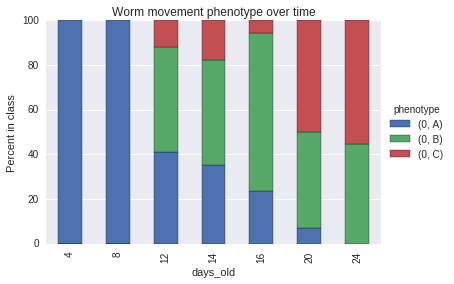

In [22]:
ax = (metadata.groupby("days_old")["behavior"]
    .value_counts(normalize = True)
    .multiply(100)
    .to_frame()
    .unstack()
    .plot(kind = "bar", stacked = True)
)

ax.set_title("Worm movement phenotype over time")
ax.set_ylabel("Percent in class")
ax.legend(title = "phenotype", loc = "center left", bbox_to_anchor = (1, 0.5));

This data does not match what was published in the paper. On days 12 and 14, there are too few A type worms, and too many B type worms. Also on day 20, there are too many C type worms and too few B type worms. On day 24, there are too few type C worms and too many type B worms.

I emailed Dr. Melov regarding this discrepancy on 2016-05-16, but he responded saying he was too busy to help.

---

## Map from GPL5859 probe ids to ORF ids

Need to read and filter the original `GPL5859.gal` file:

`GPL5859.gal` downloaded from [GEO](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL5859) on 2016-05-13. Specifically, the `GPL5859.gal.gz` file in the `Supplementary file` table at the bottom of the page [here](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GPL5859&format=file&file=GPL5859%2Egal%2Egz).

In [23]:
probes = []
for line in read_file("GPL5859.gal"):
    if "cea2" in line:
        # all probe ids start with "cea2"
        vals = line.split("\t")
        assert len(vals) == 5
        
        probes.append(vals)
        
probes = pd.DataFrame(probes,
    columns = ["block", "column", "row", "probe_id", "orf_id"]
).drop(["block", "column", "row"], axis = 1)

In [24]:
probes.shape

(22490, 2)

In [25]:
probes.head()

,probe_id,orf_id
0,cea2.c.00914,C25A1.8
1,cea2.c.02677,F21F3.6
2,cea2.c.02801,F25H2.9
3,cea2.c.04344,F56H1.4
4,cea2.c.04508,H06O01.1


In [26]:
probes.isnull().sum()

probe_id    0
orf_id      0
dtype: int64

## Map ORF ids to Wormbase ids

Wormbase identifiers file retrieved on 2016-05-13 from [WormBase](ftp://ftp.wormbase.org/pub/wormbase/releases/current-production-release/species/c_elegans/PRJNA13758/annotation/c_elegans.PRJNA13758.WS252.geneIDs.txt.gz)

In [27]:
wb_ids = pd.read_csv("../id_maps/c_elegans.PRJNA13758.WS252.geneIDs.txt", sep = ',')

In [28]:
wb_ids.shape

(50930, 5)

In [29]:
wb_ids.head()

,taxon_id,wormbase_id,gene_symbol,orf_id,status
0,6239,WBGene00000001,aap-1,Y110A7A.10,Live
1,6239,WBGene00000002,aat-1,F27C8.1,Live
2,6239,WBGene00000003,aat-2,F07C3.7,Live
3,6239,WBGene00000004,aat-3,F52H2.2,Live
4,6239,WBGene00000005,aat-4,T13A10.10,Live


In [30]:
wb_ids[["wormbase_id", "gene_symbol", "orf_id", "status"]].describe()

,wormbase_id,gene_symbol,orf_id,status
count,50930,27680,47106,50930
unique,50930,27680,47103,3
top,WBGene00047521,21ur-10019,ZC416.8,Live
freq,1,1,2,48302


### Join the ids together

In [31]:
mapping = pd.merge(probes, wb_ids, how = "left", on = "orf_id").drop("taxon_id", axis = 1)

In [32]:
mapping.shape

(22492, 5)

In [33]:
mapping.head()

,probe_id,orf_id,wormbase_id,gene_symbol,status
0,cea2.c.00914,C25A1.8,WBGene00007709,clec-87,Live
1,cea2.c.02677,F21F3.6,WBGene00017675,NaN,Live
2,cea2.c.02801,F25H2.9,WBGene00003926,pas-5,Live
3,cea2.c.04344,F56H1.4,WBGene00004505,rpt-5,Live
4,cea2.c.04508,H06O01.1,WBGene00003964,pdi-3,Live


We gained two rows in the data, which means that one ORF has multiple Wormbase ids.

In [34]:
mapping.groupby("probe_id").filter(lambda df: len(df) > 1)

,probe_id,orf_id,wormbase_id,gene_symbol,status
7038,cea2.c.25902,B0564.1,WBGene00007201,exos-4.1,Live
7039,cea2.c.25902,B0564.1,WBGene00044083,tin-9.2,Live
9267,cea2.p.24636,Y105E8A.7,WBGene00001147,eat-18,Live
9268,cea2.p.24636,Y105E8A.7,WBGene00002977,lev-10,Live


We will just discard these two genes since it is unclear which one the probe is measuring.

In [35]:
mapping = mapping.query("orf_id not in('B0564.1', 'Y105E8A.7')")

In [36]:
mapping.shape

(22488, 5)

In [37]:
mapping.isnull().sum()

probe_id           0
orf_id             0
wormbase_id     4203
gene_symbol    13405
status          4203
dtype: int64

In [38]:
mapping["status"].value_counts()

Live          18046
Suppressed      239
Name: status, dtype: int64

Based on a hand evaluation of the suppressed genes, it seems that they are mostly transposons, and are therefore not going to be included.

### Good probes

We will only take the probes which have Wormbase IDs and are currently being used as identifiers ("live" ids). We will ignore those without Wormbase ids since it is unclear what they are referring to.

In [39]:
id_map = mapping.query("status == 'Live'")

In [40]:
id_map.shape

(18046, 5)

In [41]:
id_map.head()

,probe_id,orf_id,wormbase_id,gene_symbol,status
0,cea2.c.00914,C25A1.8,WBGene00007709,clec-87,Live
1,cea2.c.02677,F21F3.6,WBGene00017675,NaN,Live
2,cea2.c.02801,F25H2.9,WBGene00003926,pas-5,Live
3,cea2.c.04344,F56H1.4,WBGene00004505,rpt-5,Live
4,cea2.c.04508,H06O01.1,WBGene00003964,pdi-3,Live


### Save id mapping to file

In [42]:
id_map.drop("status", axis = 1).to_csv("GPL5859_id_map.tsv", sep = '\t', index = False)

---

## Putting everything together

In [43]:
exp.shape

(22490, 105)

In [44]:
exp.head()

,ID_REF,GSM308821,GSM308822,GSM308823,GSM308824,GSM308825,GSM308826,GSM308827,GSM308828,GSM308829,...,GSM308915,GSM308916,GSM308917,GSM308918,GSM308919,GSM308920,GSM308921,GSM308922,GSM308923,GSM308924
0,cea2.3.00017,0.026223,0.013543,-0.961007,-0.829387,-0.838482,-0.428721,0.558073,-0.530957,-0.238006,...,2.238899,-0.331698,0.347295,0.478094,-2.038200,1.176916,1.948561,-0.108291,-0.819321,-2.679702
1,cea2.3.00036,-1.074264,-0.505992,-0.779248,-1.108055,-0.875029,-0.260945,-0.839102,0.628079,-0.561911,...,-0.881748,-1.172952,-0.321608,-0.203567,-0.717246,-0.062770,0.123618,-1.829057,-0.892860,-0.602018
2,cea2.3.00043,0.717738,0.540692,-2.119586,0.323724,0.598483,0.124900,-0.222288,0.707347,0.110682,...,-0.966190,0.388561,-0.091064,0.467543,-0.757086,0.269940,0.579565,-0.393049,0.365195,-0.482556
3,cea2.3.00049,-0.265565,1.147914,0.189793,1.875017,0.288013,0.194361,0.799468,1.440917,-0.728799,...,-0.126092,-0.726546,0.863832,-1.356532,-0.030879,-0.201753,-0.483370,0.433869,-0.220468,-0.917110
4,cea2.3.00084,2.145240,0.260129,-0.040587,1.794957,2.236226,2.188161,1.321817,1.497870,1.422868,...,1.190913,1.602906,0.740200,3.095513,-0.016649,0.944288,0.319632,1.750920,1.493000,1.220239


Drop any genes which had no expression in any sample:

In [45]:
raw = exp.dropna(axis = 0, how = "any")

In [46]:
raw.shape

(16181, 105)

We ended up dropping 6309 genes because they had no expression in at least one sample.

## Reshape to long form

In [47]:
long = (pd.melt(raw, id_vars = ["ID_REF"])
    .rename(columns = {"ID_REF": "probe_id", "variable": "geo_id", "value": "log2_exp"})
)

In [48]:
long.shape

(1682824, 3)

### Add gene annotation information

In [49]:
long = pd.merge(long, id_map, how = "inner", on = "probe_id")

In [50]:
long.shape

(1330160, 7)

In [51]:
long.head()

,probe_id,geo_id,log2_exp,orf_id,wormbase_id,gene_symbol,status
0,cea2.3.00017,GSM308821,0.026223,AC3.2,WBGene00007070,ugt-49,Live
1,cea2.3.00017,GSM308822,0.013543,AC3.2,WBGene00007070,ugt-49,Live
2,cea2.3.00017,GSM308823,-0.961007,AC3.2,WBGene00007070,ugt-49,Live
3,cea2.3.00017,GSM308824,-0.829387,AC3.2,WBGene00007070,ugt-49,Live
4,cea2.3.00017,GSM308825,-0.838482,AC3.2,WBGene00007070,ugt-49,Live


### Add sample metadata

In [52]:
final = pd.merge(
    long, metadata, how = "left",
    left_on = "geo_id", right_on = "geo_accession"
).drop(["geo_id", "status"], axis = 1)

In [53]:
final.head()

,probe_id,log2_exp,orf_id,wormbase_id,gene_symbol,title,geo_accession,days_old,behavior
0,cea2.3.00017,0.026223,AC3.2,WBGene00007070,ugt-49,tg10,GSM308821,8,A
1,cea2.3.00017,0.013543,AC3.2,WBGene00007070,ugt-49,tg100,GSM308822,4,A
2,cea2.3.00017,-0.961007,AC3.2,WBGene00007070,ugt-49,tg109,GSM308823,8,A
3,cea2.3.00017,-0.829387,AC3.2,WBGene00007070,ugt-49,tg101,GSM308824,14,A
4,cea2.3.00017,-0.838482,AC3.2,WBGene00007070,ugt-49,tg102,GSM308825,24,C


In [54]:
final.groupby("geo_accession")["wormbase_id"].nunique().value_counts()

12294    104
Name: wormbase_id, dtype: int64

We now have a total of 12294 genes measured for all 104 samples.

## Save to file

In [55]:
final.to_csv("filtered_expression.tsv", sep = '\t', index = False)